# Imports

In [1]:
# General Imports
import numpy as np
import pandas as pd
import math
import pickle
import os
from IPython.display import display

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette('flare', as_cmap = True)
from mpl_toolkits.mplot3d import Axes3D
import squarify
from math import pi

# Dates
import datetime
from datetime import datetime
from datetime import timedelta

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer

# Clustering
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering

from sklearn.neighbors import NearestNeighbors

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance

import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.hierarchy import dendrogram

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

#!pip install kneed
from kneed import KneeLocator

from collections import Counter

# PCA
from sklearn.decomposition import PCA
from matplotlib.patches import Circle

import warnings
warnings.simplefilter(action = 'ignore')

# Sommaire (pour jupyter notebook)
#!pip install jyquickhelper
#from jyquickhelper import add_notebook_menu
#add_notebook_menu()

In [2]:
# Set display preferences
pd.set_option('display.max_row', 250)
pd.set_option('display.max_column', 100)
#pd.set_option('display.precision', 5)

# Import des données

## Import

In [3]:
# import des données

# Chemin d'accès aux données (à modifier si code en local)
#path = '/content/drive/MyDrive/OpenClassrooms/Projet5/' #-> pour colab
path = '' #-> en local

filepath = os.path.join(path, 'df')

with open(filepath, 'rb') as f:
    df_final = pickle.load(f)

df_final.head()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,payment_sequential,payment_installments,payment_value,review_score,review_time,order_time,delivery_error_time,order_preparation_time,shipping_limit_respect,review,distance,Count,order_item_id,customer_city,customer_state,order_status,payment_type,purchase_year,purchase_month,purchase_dayofweek,purchase_day,purchase_hour,product_category_,product_category_Electronics and Technology,product_category_Fashion and Accessories,product_category_Furniture and Home Decor,product_category_Leisure and Miscellaneous
0,1.063032,-0.700400,-0.113595,0.051337,-0.13044,-0.709001,-0.096009,0.685860,-0.222477,1.367381,0.781083,0.756144,-0.530952,-0.331713,0.209502,-0.277408,1.395281,0,0,1,1,2017.0,11.0,3.0,30.0,21.0,False,False,False,True,False
1,-0.613695,0.292874,-0.113595,-0.291392,-0.13044,-0.709001,-0.552778,-0.920141,0.042718,0.142996,-0.116567,0.986293,-0.757613,-0.331713,0.020660,-0.277408,-0.290293,0,0,1,1,2017.0,10.0,6.0,29.0,18.0,False,False,False,False,True
2,0.329464,-0.370989,-0.731422,-0.564939,-0.13044,0.085830,-0.653538,0.685860,-0.038747,-0.397535,-3.234604,0.088862,1.011418,2.654219,-0.071021,-0.277408,-0.290293,0,0,1,1,2018.0,5.0,0.0,7.0,0.0,False,False,False,False,True
3,-2.395219,1.188669,-0.731422,-0.234138,-0.13044,2.072909,-0.062612,-0.117140,0.209933,-1.024820,-0.678373,-0.629023,0.546069,-0.331713,-0.103798,-0.277408,-0.290293,0,0,1,1,2017.0,8.0,6.0,27.0,21.0,False,True,False,False,False
4,0.434259,2.934881,-0.731422,-0.604699,-0.13044,-0.709001,-0.726702,0.685860,-0.283107,-0.042996,-1.967422,0.771955,-1.192165,-0.331713,-1.118277,-0.277408,-0.290293,0,0,1,1,2017.0,1.0,3.0,5.0,13.0,False,True,False,False,False


In [4]:
df_final.shape

(87099, 31)

# Jeu de données réduit

## Choix variables

In [5]:
# Lister les colonnes du df
df_final.columns

Index(['product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'payment_sequential',
       'payment_installments', 'payment_value', 'review_score', 'review_time',
       'order_time', 'delivery_error_time', 'order_preparation_time',
       'shipping_limit_respect', 'review', 'distance', 'Count',
       'order_item_id', 'customer_city', 'customer_state', 'order_status',
       'payment_type', 'purchase_year', 'purchase_month', 'purchase_dayofweek',
       'purchase_day', 'purchase_hour', 'product_category_',
       'product_category_Electronics and Technology',
       'product_category_Fashion and Accessories',
       'product_category_Furniture and Home Decor',
       'product_category_Leisure and Miscellaneous'],
      dtype='object')

In [6]:
df_final.reset_index(drop = True, inplace = True)

In [7]:
# reconstituer date d'achat
df_final['Date_achat'] = df_final.apply(lambda row: datetime.strptime(f"{int(row.purchase_year)}-{int(row.purchase_month)}-{int(row.purchase_day)}", '%Y-%m-%d'), axis = 1)
df_final['Date_achat']

0       2017-11-30
1       2017-10-29
2       2018-05-07
3       2017-08-27
4       2017-01-05
           ...    
87094   2018-04-30
87095   2017-12-15
87096   2018-05-07
87097   2017-06-15
87098   2017-05-03
Name: Date_achat, Length: 87099, dtype: datetime64[ns]

In [8]:
# Choix des variables (d'après résultats des analyses precedantes) :
# (garder nb de commandes et nb de produits/commandes séparés)

df_reduit = df_final[[
    'Count',
    'order_item_id',
    #'product_name_lenght',
    'product_description_lenght',
    #'product_photos_qty',
    'product_weight_g',
    'payment_sequential', # nb de types de paiement
    'payment_installments', # paiement en plusieurs fois
    'payment_value',
    #'review_score',
    #'review_time',
    #'order_time',
    #'delivery_error_time',
    #'order_preparation_time',
    #'shipping_limit_respect',
    #'purchase_month',
    #'purchase_dayofweek',
    #'purchase_day',
    #'purchase_hour',
    'review',
    #'distance'
    ]]

In [9]:
df_reduit.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review'],
      dtype='object')

In [10]:
df_reduit.reset_index(drop = True, inplace = True)

In [11]:
df_reduit

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review
0,-0.277408,1.395281,-0.700400,0.051337,-0.13044,-0.709001,-0.096009,-0.331713
1,-0.277408,-0.290293,0.292874,-0.291392,-0.13044,-0.709001,-0.552778,-0.331713
2,-0.277408,-0.290293,-0.370989,-0.564939,-0.13044,0.085830,-0.653538,2.654219
3,-0.277408,-0.290293,1.188669,-0.234138,-0.13044,2.072909,-0.062612,-0.331713
4,-0.277408,-0.290293,2.934881,-0.604699,-0.13044,-0.709001,-0.726702,-0.331713
...,...,...,...,...,...,...,...,...
87094,0.950211,2.238068,-0.317208,0.309775,-0.13044,-0.311585,1.268967,5.640151
87095,-0.277408,-0.290293,-1.172667,0.468814,-0.13044,-0.311585,-0.601271,-0.331713
87096,-0.277408,-0.290293,-1.071827,-0.386020,-0.13044,-0.311585,-0.570279,2.654219
87097,-0.277408,-0.290293,-0.720568,-0.457190,-0.13044,0.880662,1.400766,-0.331713


## Kmeans

### Choix du K optimal

In [ ]:
%%time

# KElbowVisualizer - 'distortion' metric (default metric)
# Instantiate the clustering model and visualizer
model = KMeans()
d_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'distortion'
    )

# Fit the data to the visualizer
d_visualizer.fit(df_reduit)

# Finalize and render the figure
d_visualizer.show()

In [ ]:
%%time

# KElbowVisualizer - 'calinski_harabasz' metric
# Instantiate the clustering model and visualizer
model = KMeans()
ch_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'calinski_harabasz'
    )

# Fit the data to the visualizer
ch_visualizer.fit(df_reduit)

# Finalize and render the figure
ch_visualizer.show()   

In [ ]:
%%time

# KElbowVisualizer - 'silhouette' metric (le plus long)
# Instantiate the clustering model and visualizer
model = KMeans()
s_visualizer = KElbowVisualizer(
    model,
    k = (3, 15),
    size = (1080, 500),
    metric = 'silhouette'
    )

# Fit the data to the visualizer
s_visualizer.fit(df_reduit)

# Finalize and render the figure
s_visualizer.show()

In [ ]:
# Comparer le k optimal des différentes métriques :

# distortion
k_distortion = d_visualizer.elbow_value_
print(f'Nombre optimal de clusters - distortion metric : k = {k_distortion}')

# calinski harabasz
k_calinski_harabasz = ch_visualizer.elbow_value_
print(f'Nombre optimal de clusters - calinski harabasz metric : k = {k_calinski_harabasz}')

# silhouette
k_silhouette = s_visualizer.elbow_value_
print(f'Nombre optimal de clusters - silhouette metric : k = {k_silhouette}')

In [12]:
########## Choix de k ##########

# test avec 3
k = 3
#silhouette_kmeans = 0.37

# test avec 7
#k = 7
#silhouette_kmeans = 0.37

# d'après le graph, le max semble plutôt être atteint avec k = 4
#k = 4
#silhouette_kmeans = 0.38

### Kmeans clustering

In [13]:
# faire une gridsearch ?

In [14]:
%%time

# Instantiate the clustering model
model = KMeans(
    n_clusters = k # nb de clusters qu'on veut avoir
    #n_init = 10, # nb d'initialisations qu'on veut faire - 10 = valeur par défaut
    # #max_iter = 300, # nb d'itérations max - par défaut 300
    # #init = 'k-means++'' # quelle stratégie d'initialisation on utilise
    )

# K-Means++ -> méthode d'initialisation qui consiste à placer les centroïdes sur des points du dataset éloignés les uns des autres - facilite convergence

# Entrainer le modèle
model.fit(df_reduit)
# model.labels_ ou
model.predict(df_reduit)

CPU times: user 5.43 s, sys: 745 ms, total: 6.17 s
Wall time: 898 ms


array([0, 0, 1, ..., 1, 2, 0], dtype=int32)

In [15]:
# Centroids (= centres des clusters)
centroids = model.cluster_centers_
centroids

array([[-0.14112984, -0.12549342, -0.02739555, -0.25734338,  0.04654488,
        -0.37585704, -0.28979979, -0.33171306],
       [ 0.41558291, -0.00849851, -0.01497078, -0.11318811, -0.06928969,
        -0.02915344,  0.17987005,  2.80816301],
       [ 0.22977544,  0.38271601,  0.08973725,  0.83000764, -0.10776167,
         1.14799353,  0.78965612, -0.32417128]])

In [16]:
centroids.shape

(3, 8)

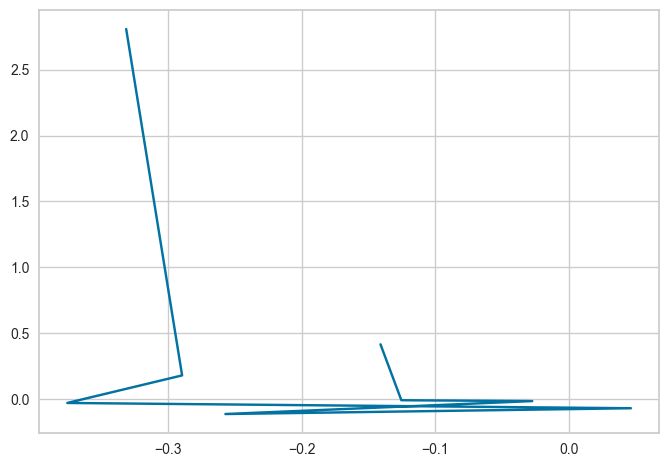

In [17]:
plt.plot(centroids[0], centroids[1])

In [18]:
########## SILHOUETTE SCORE ##########
# pour évaluer le clustering
# A score closer to 1 indicates that the clustering is good, while a score closer to -1 indicates that the clustering is bad.
silhouette_kmeans = round(silhouette_score(df_reduit, model.fit_predict(df_reduit)), 2)
print('The average silhouette score is:', silhouette_kmeans)

The average silhouette score is: 0.35


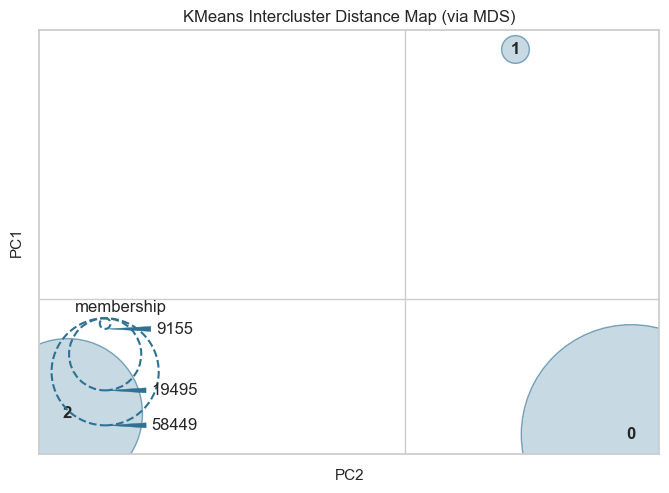

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [19]:
########## Distance intercluster ##########
# Intercluster distance Map with best k

distance_visualizer = InterclusterDistance(KMeans(k))
distance_visualizer.fit(df_reduit)
distance_visualizer.show()

In [20]:
########## CONCLUSIONS ##########
# Silhouette score de 0.35 -> acceptable
# 3 clusters bien distincts
# un des 3 clusters semble bien plus petit que les autres (en terme d'effectif)

### Description des clusters

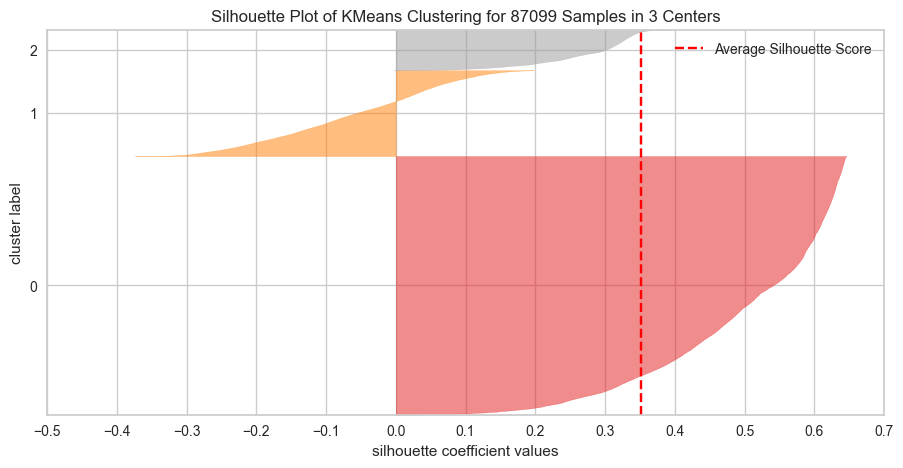

CPU times: user 5min 34s, sys: 50.1 s, total: 6min 24s
Wall time: 1min 50s


<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 87099 Samples in 3 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [21]:
%%time
########## Visualisation des clusters ##########

# Instantiate the clustering model and visualizer
kmeans1 = KMeans(n_clusters = k, init = 'k-means++', random_state = 42)
visualizer = SilhouetteVisualizer(kmeans1, size = (1080, 500))

# Fit the data to the visualizer
visualizer.fit(df_reduit)

# Finalize and render the figure
visualizer.show()

In [22]:
# un cluster bien plus gros que les autres -> surement possible de le diviser si on améliore le clustering ?

In [23]:
# Créer une copie du df pour ajouter les clusters et observer leur comportement
df_clusters = df_reduit

labels = model.labels_
df_clusters['cluster_num'] = labels
df_clusters.head()

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num
0,-0.277408,1.395281,-0.700400,0.051337,-0.13044,-0.709001,-0.096009,-0.331713,0
1,-0.277408,-0.290293,0.292874,-0.291392,-0.13044,-0.709001,-0.552778,-0.331713,0
2,-0.277408,-0.290293,-0.370989,-0.564939,-0.13044,0.085830,-0.653538,2.654219,1
3,-0.277408,-0.290293,1.188669,-0.234138,-0.13044,2.072909,-0.062612,-0.331713,2
4,-0.277408,-0.290293,2.934881,-0.604699,-0.13044,-0.709001,-0.726702,-0.331713,0


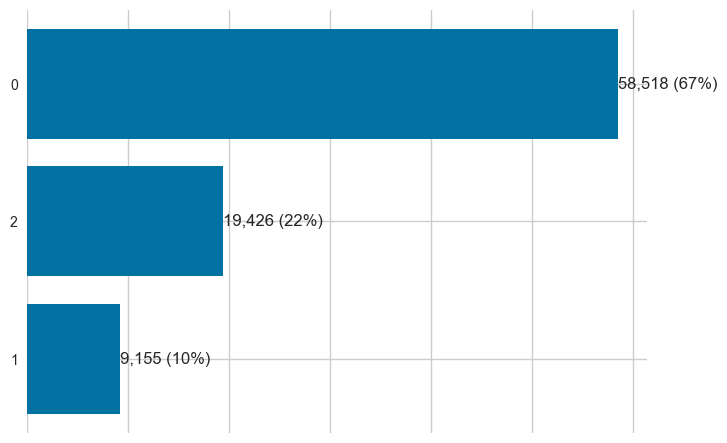

In [24]:
# Nombre de clients dans chaque cluster
segments_counts = df_clusters['cluster_num'].value_counts().sort_values(ascending = True)

# Plot
fig, ax = plt.subplots()
bars = ax.barh(
        range(len(segments_counts)),
        segments_counts,
        #color = 'silver'
        )
ax.set_frame_on(False)
ax.tick_params(left = False, bottom = False, labelbottom = False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)
for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value), int(value*100/segments_counts.sum())),
                va = 'center',
                ha = 'left'
               )
plt.show()

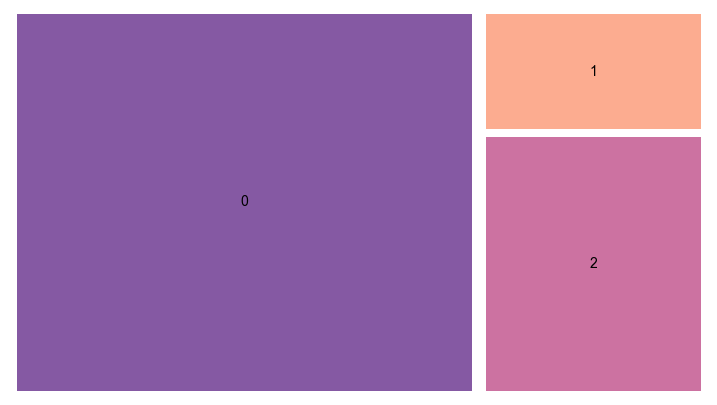

In [25]:
#Autre forme de visualisation

# Isoler valeurs et labels des clusters
values = df_clusters['cluster_num'].value_counts().values
labels = df_clusters['cluster_num'].value_counts().index

# Squarify plot
plt.figure(figsize = (9, 5))
squarify.plot(
    values,
    label = labels,
    text_kwargs = {'fontsize': 10, 'color': 'black'},
    pad = 0.20,
    color = sns.color_palette('magma', len(values)),
    alpha = 0.7
    )
plt.axis('off')
plt.show()

In [26]:
# Faire la moyenne pour expliquer les clusters
df_clusters.groupby('cluster_num').mean().reset_index(drop = True)

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review
0,-0.141237,-0.125391,-0.027781,-0.257903,0.046596,-0.376018,-0.290023,-0.331713
1,0.415583,-0.008499,-0.014971,-0.113188,-0.069290,-0.029153,0.179870,2.808163
2,0.229602,0.381728,0.090742,0.830237,-0.107709,1.146439,0.788884,-0.324181


In [27]:
df_clusters.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num'],
      dtype='object')

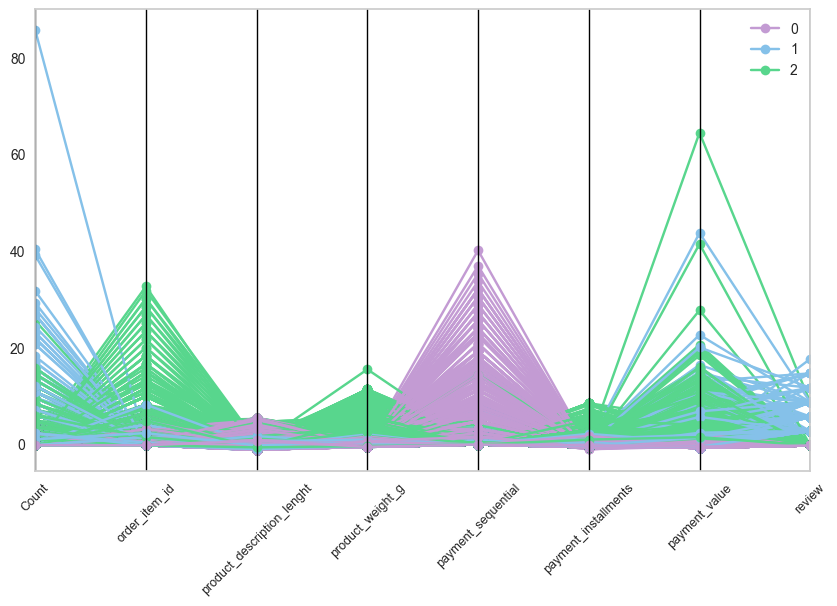

In [40]:
# Parallel_coordinates plot
# FAIRE PHRASE POUR EXPLIQUER CE QUE C'EST
# https://www.data-to-viz.com/graph/parallel.html

plt.figure(figsize = (10, 6))
pd.plotting.parallel_coordinates(df_clusters, 'cluster_num', marker = 'o', color = ['#c39bd3', '#85c1e9', '#58d68d']) # pour choisir couleurs : color = []
plt.xticks(fontsize = 9, rotation = 45)
plt.show()

In [29]:
# Grouper les données par cluster en ne gardant que la moyenne
mean = df_clusters.groupby('cluster_num').mean()
mean['cluster_num'] = mean.index
mean

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num
cluster_num,,,,,,,,,
0,-0.141237,-0.125391,-0.027781,-0.257903,0.046596,-0.376018,-0.290023,-0.331713,0
1,0.415583,-0.008499,-0.014971,-0.113188,-0.069290,-0.029153,0.179870,2.808163,1
2,0.229602,0.381728,0.090742,0.830237,-0.107709,1.146439,0.788884,-0.324181,2


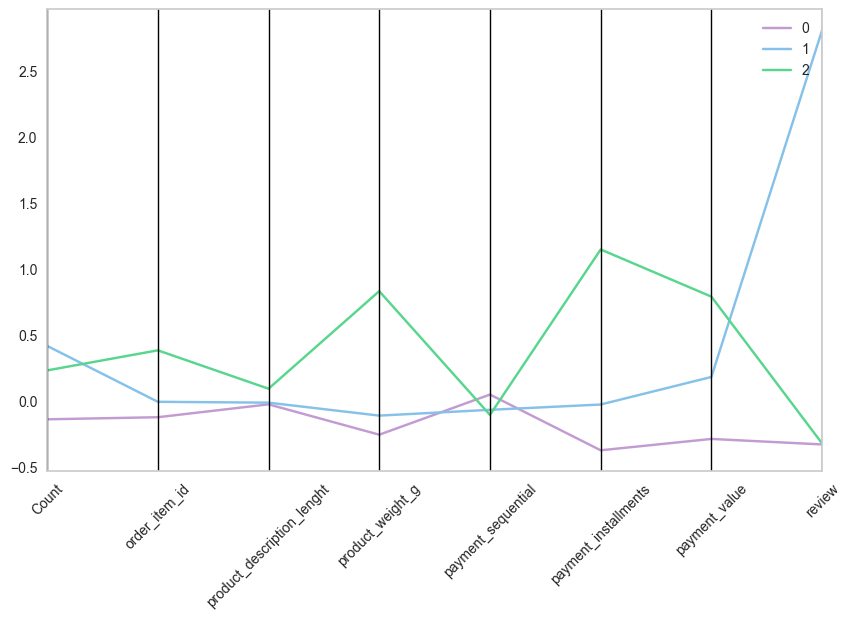

In [39]:
# Parallel_coordinates plot

plt.figure(figsize = (10, 6))
pd.plotting.parallel_coordinates(mean, 'cluster_num', color = ['#c39bd3', '#85c1e9', '#58d68d'])
plt.xticks(fontsize = 10, rotation = 45)
plt.show()

# ARI Score

In [116]:
# tester stabilité de la segmentation client dans le temps et voir à quel moment les clients changent de cluster
# pour ça, on réitère les étapes précedantes sur des périodes décalées dans le temps de 30j, 60j, 90j...

# The higher the ARI value, the closer the two clusterings are to each other. 
# It ranges from -1 to 1, where 1 indicates perfect agreement between the two clusterings, 
# 0 indicates a random agreement and -1 indicates that the two clusterings are completely different

In [117]:
df_clusters.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num'],
      dtype='object')

In [118]:
# concat avec date
df_ari = pd.concat([df_clusters, df_final['Date_achat']], axis = 1)
df_ari

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
0,-0.277408,1.395281,-0.700400,0.051337,-0.13044,-0.709001,-0.096009,-0.331713,0,2017-11-30
1,-0.277408,-0.290293,0.292874,-0.291392,-0.13044,-0.709001,-0.552778,-0.331713,0,2017-10-29
2,-0.277408,-0.290293,-0.370989,-0.564939,-0.13044,0.085830,-0.653538,2.654219,1,2018-05-07
3,-0.277408,-0.290293,1.188669,-0.234138,-0.13044,2.072909,-0.062612,-0.331713,2,2017-08-27
4,-0.277408,-0.290293,2.934881,-0.604699,-0.13044,-0.709001,-0.726702,-0.331713,0,2017-01-05
...,...,...,...,...,...,...,...,...,...,...
87094,0.950211,2.238068,-0.317208,0.309775,-0.13044,-0.311585,1.268967,5.640151,1,2018-04-30
87095,-0.277408,-0.290293,-1.172667,0.468814,-0.13044,-0.311585,-0.601271,-0.331713,0,2017-12-15
87096,-0.277408,-0.290293,-1.071827,-0.386020,-0.13044,-0.311585,-0.570279,2.654219,1,2018-05-07
87097,-0.277408,-0.290293,-0.720568,-0.457190,-0.13044,0.880662,1.400766,-0.331713,2,2017-06-15


In [119]:
# order by date et reset index

df_ari.sort_values(['Date_achat'], inplace = True)
df_ari

,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
78283,-0.277408,-0.290293,-0.856702,0.071217,-0.13044,0.085830,-0.383996,-0.331713,0,2016-10-03
19745,0.950211,-0.290293,0.863460,-0.554999,-0.13044,-0.112877,0.690352,-0.331713,0,2016-10-03
28527,-0.277408,-0.290293,-0.402922,-0.485420,-0.13044,-0.709001,-0.634858,-0.331713,0,2016-10-03
18431,-0.277408,1.395281,3.281098,-0.246861,-0.13044,1.675493,-0.113841,-0.331713,2,2016-10-04
16734,-0.277408,-0.290293,-0.838215,-0.401924,-0.13044,2.867740,0.442556,-0.331713,2,2016-10-04
...,...,...,...,...,...,...,...,...,...,...
32193,-0.277408,-0.290293,0.620604,-0.465540,-0.13044,-0.709001,-0.377015,-0.331713,0,2018-08-29
19940,-0.277408,-0.290293,2.778579,-0.493372,-0.13044,-0.709001,-0.469189,2.654219,1,2018-08-29
32993,-0.277408,-0.290293,-0.394519,-0.346261,-0.13044,-0.311585,-0.255923,-0.331713,0,2018-08-29
74572,-0.277408,-0.290293,-0.216368,-0.529155,-0.13044,-0.709001,0.021591,-0.331713,0,2018-08-29


In [120]:
df_ari.reset_index(drop = True, inplace = True)

In [121]:
# définir timedelta

# premier date dispo = 03/10/2016
# dernière date dispo = 29/08/2018

# quasiment 2ans de données
# timedelta = prendre 6 mois glissants ? 180j

# écart entre les dates et les lignes n'est pas constant donc passer automatiquement pas les dates

date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)
print(date_fin)

# filtrer jeu de données
filter_date = (df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin) 
df_date = df_ari[filter_date].copy()
df_date

2017-04-01 00:00:00


,Count,order_item_id,product_description_lenght,product_weight_g,payment_sequential,payment_installments,payment_value,review,cluster_num,Date_achat
3,-0.277408,1.395281,3.281098,-0.246861,-0.13044,1.675493,-0.113841,-0.331713,2,2016-10-04
4,-0.277408,-0.290293,-0.838215,-0.401924,-0.13044,2.867740,0.442556,-0.331713,2,2016-10-04
5,-0.277408,-0.290293,-0.868467,0.071217,-0.13044,-0.311585,-0.528485,-0.331713,0,2016-10-04
6,-0.277408,1.395281,-0.838215,-0.048063,-0.13044,2.867740,-0.340739,-0.331713,2,2016-10-04
7,-0.277408,-0.290293,1.050854,0.091096,-0.13044,-0.709001,-0.312577,-0.331713,0,2016-10-04
...,...,...,...,...,...,...,...,...,...,...
4802,-0.277408,-0.290293,-0.517207,2.933917,-0.13044,-0.311585,-0.690616,-0.331713,2,2017-03-31
4803,-0.277408,-0.290293,-0.636535,-0.435720,-0.13044,0.085830,-0.651746,-0.331713,0,2017-03-31
4804,-0.277408,-0.290293,-0.260065,1.721245,-0.13044,0.483246,1.186510,-0.331713,2,2017-03-31
4805,-0.277408,-0.290293,0.012203,1.097415,-0.13044,2.072909,2.702861,-0.331713,2,2017-03-31


In [122]:
# garder les clients quand j'avance dans le temps -> un client acquis reste acquis 
# fixer base de clients (6mois) et ajouter des nouveaux clients - ne pas en enlever

In [123]:
df_date.columns

Index(['Count', 'order_item_id', 'product_description_lenght',
       'product_weight_g', 'payment_sequential', 'payment_installments',
       'payment_value', 'review', 'cluster_num', 'Date_achat'],
      dtype='object')

In [124]:
# surtout ajout de nouveaux clients - actuels clients pas susceptibles de changer de comportement
# prendre intervalle de base suffisamment grand et glisser dans le temps pour voir impact de l'arrivée de nouveaux clients sur nos clusters

# sujet sur l'integration des nouveaux clients dans le calcul du score ARI
# calculer score ari par rapport à t0

2017-04-01 00:00:00


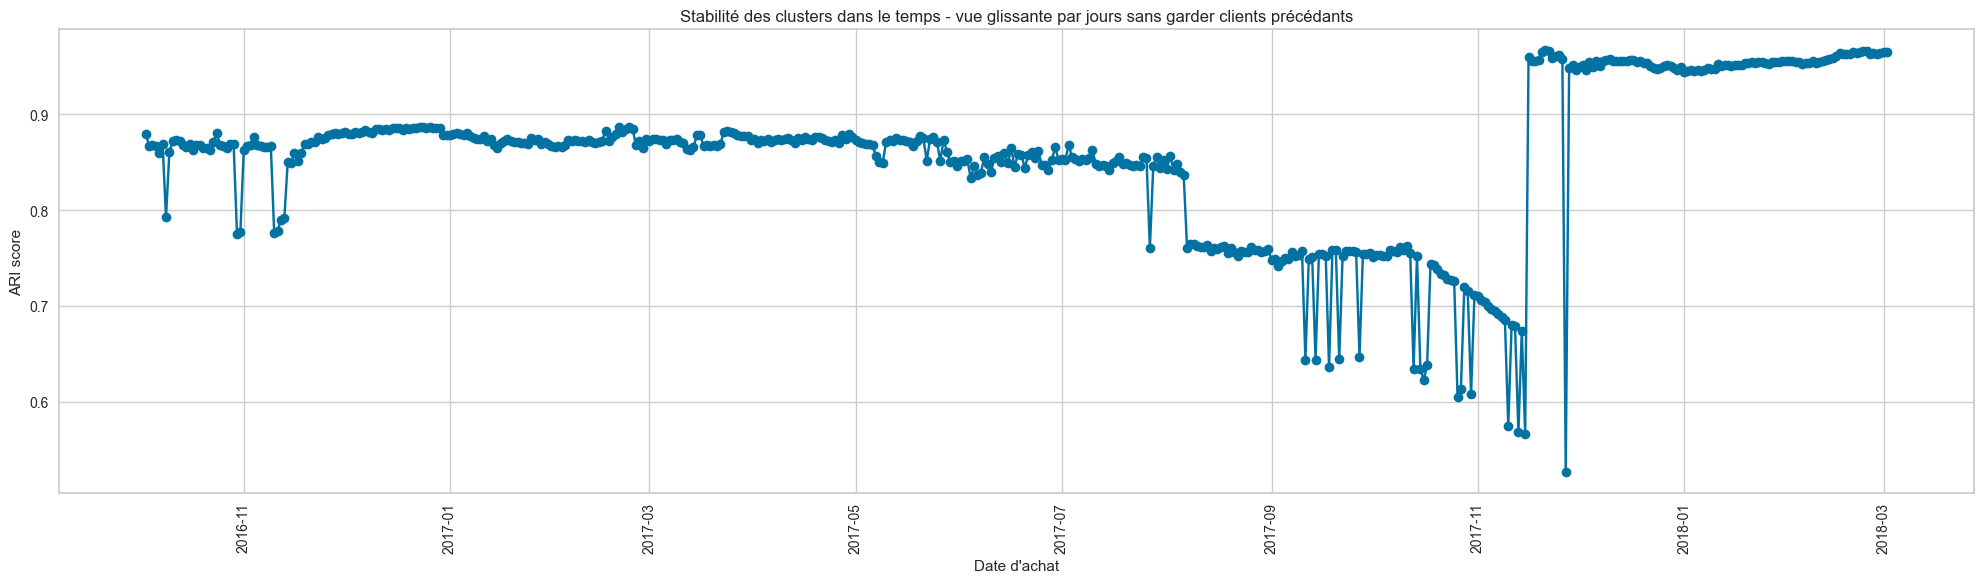

CPU times: user 18min 57s, sys: 3min 12s, total: 22min 10s
Wall time: 2min 54s


In [125]:
%%time

# ari score -> labels true vs labels pred

# dernière date dispo = 29/08/2018
last_day = pd.to_datetime('2018-08-29')

# intervalle de temps
date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)
print(date_fin)

# liste vide pour stocker ari score et première date de chaque paquet de données
ari_values = []
date_achat = []

# avancer d'un jour dans le temps jusqu'à ce qu'on atteigne la dernière date du jeu de données
while date_fin <= last_day:
    date_achat.append(date_debut)

    # filtrer dates et prendre 6 mois de données
    #filter_date = (df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin) 
    #df_date = df_ari[filter_date].copy()
    df_date = df_ari.loc[(df_ari['Date_achat'] > date_debut) & (df_ari['Date_achat'] < date_fin)]

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    #data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
    #   'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

    data_cluster = df_date.drop(['Date_achat', 'cluster_num'], axis = 1)

    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # incrément d'un jour
    date_debut += timedelta(days = 1)
    date_fin += timedelta(days = 1)

# Figure résultat
plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Stabilité des clusters dans le temps - vue glissante par jours sans garder clients précédants')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()


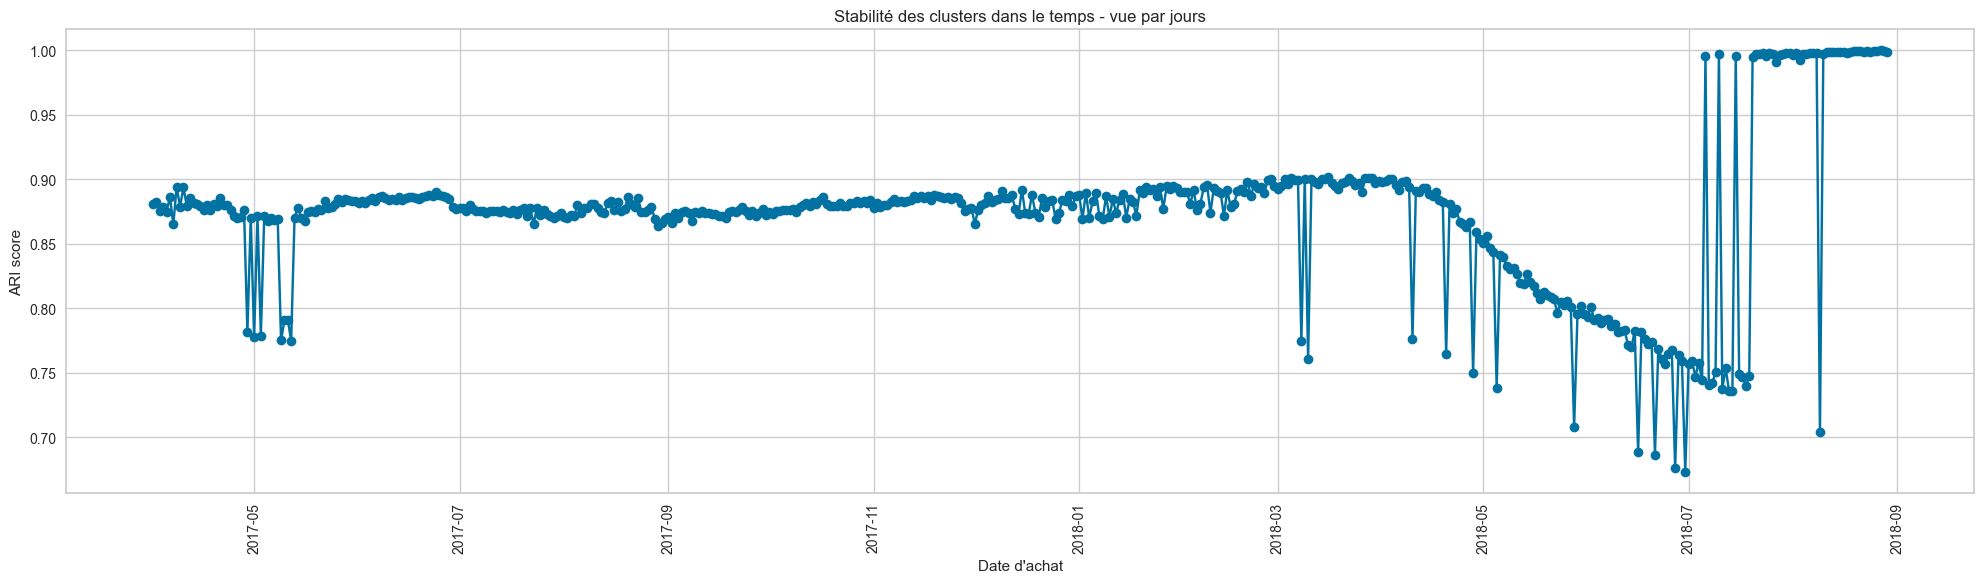

CPU times: user 23min 6s, sys: 4min 10s, total: 27min 17s
Wall time: 3min 32s


In [127]:
%%time

# Même chose en comparant avec t0

# dernière date dispo = 29/08/2018
last_day = pd.to_datetime('2018-08-29')

# intervalle de temps
date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 180)

# liste vide pour stocker ari score
ari_values = []
date_achat = []

while date_fin <= last_day:
    date_achat.append(date_fin)

    # filtrer dates et prendre 6 mois de données
    filter_date = (df_ari['Date_achat'] < date_fin) 
    df_date = df_ari[filter_date].copy()

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()
    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # incrément d'un jour (pour la date de fin seulement)
    date_debut += timedelta(days = 1)
    date_fin += timedelta(days = 1)

plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Stabilité des clusters dans le temps - vue par jours')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Changer dates -> prendre date de 'fin' de mes 6 mois et non date de début
# instabilité de survient que fin 2017 -> changement de comportements ou base devient trop grande - base de clients suffisamment représentative ? en élargissant la taille de la base client de ref, est-ce que l'instabilité arrive plus tôt ? (prendre plus que 6mois) plus la base client sera grande, plus on va se rapprocher des conditions réelles et plus ça sera intéressant
# faire quelques tests de taille de base de réference

# comment choisir seuil de rafraichissement ?
# dans la réalité, il faudrait croiser évolution du score ari avec données campagnes marketing

# voir slack

In [ ]:
# forte inflexion après 1 an sur les clients initiaux. Il faudra donc prévoir la maintenance du programme de segmentation et une redéfinition des clusters de clients au minimum tous les ans pour garantir un résultat optimal. 

In [ ]:
# question : pas de différence entre les deux tests (depuis t0 et en glissant dans le temps) -> donc a priori la conservation ou non des clients déjà acquis n'influence pas la stabilité du clustering

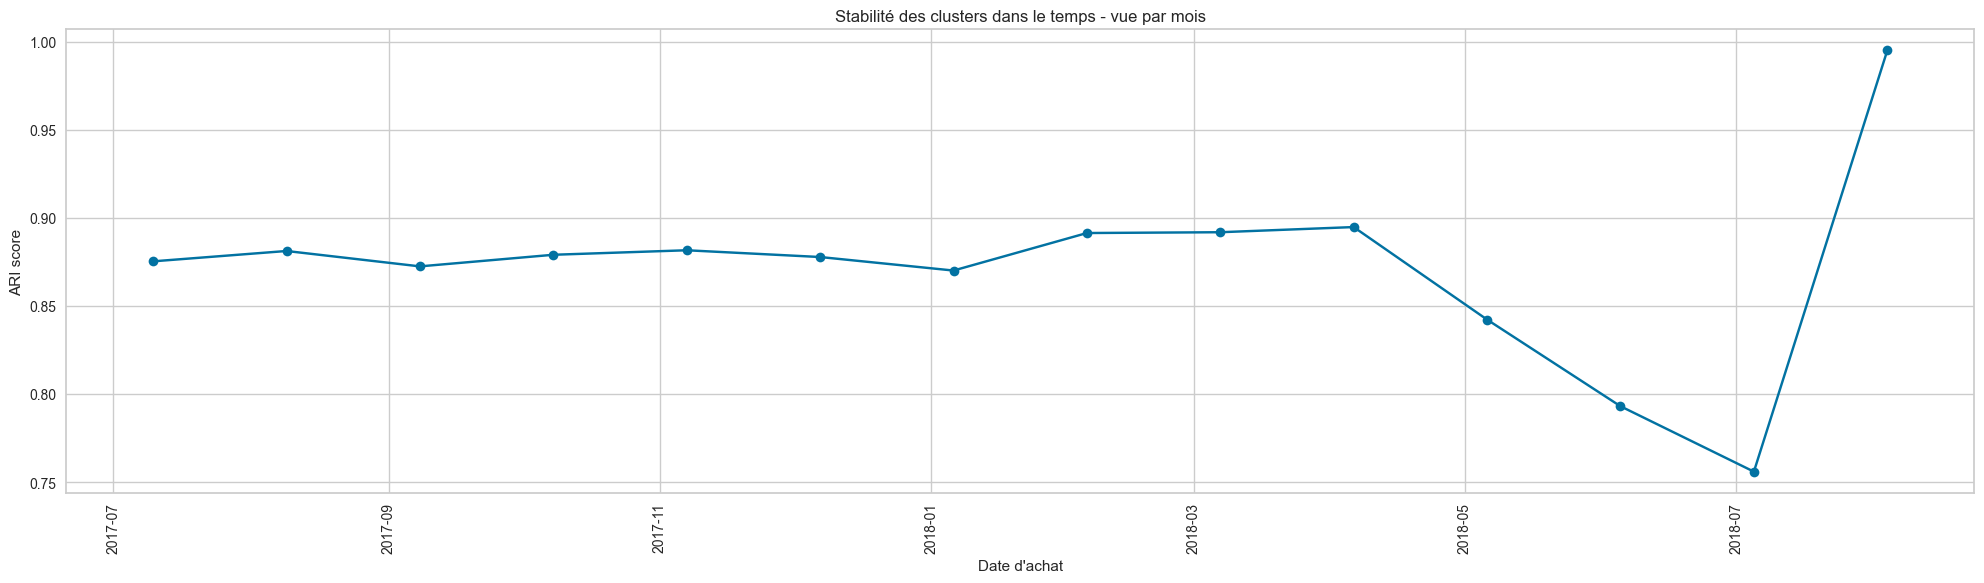

CPU times: user 48.5 s, sys: 8.49 s, total: 57 s
Wall time: 7.54 s


In [128]:
%%time

# Même chose en changeant d'echelle (mois)
# (comparaison t0)

# dernière date dispo = 29/08/2018
last_day = pd.to_datetime('2018-08-29')

# intervalle de temps
date_debut = pd.to_datetime('2016-10-03')
date_fin = date_debut + pd.Timedelta(days = 280)

# liste vide pour stocker ari score
ari_values = []
date_achat = []

while date_fin <= last_day:
    date_achat.append(date_fin)

    # filtrer dates et prendre 6 mois de données
    filter_date = (df_ari['Date_achat'] < date_fin) 
    df_date = df_ari[filter_date].copy()

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()
    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # incrément d'un jour (pour la date de fin seulement)
    date_fin += timedelta(days = 30)

plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Stabilité des clusters dans le temps - vue par mois')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
# afficher score sur graph
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# première inflexion -> pas assez de données pour que clustering soit robuste -> à ignorer
# seconde inflexion autour d'octobre 2017 (au bout d'un an) - confirme hypothèse de la vue par jour

# remontée finale -> ajout de clients qui recollent au clustering initial

# regarder aussi par semaine
# jouer avec taille de base clients de référence

In [ ]:
%%time

# Même chose en reculant dans le temps

# dernière date dispo = 29/08/2018
#first_day = pd.to_datetime('2016-10-03')
first_day = pd.to_datetime('2016-11-15')

# intervalle de temps
date_fin = pd.to_datetime('2018-08-29')
date_debut = date_fin - pd.Timedelta(days = 180)
print(date_debut)
date_data = date_debut

# liste vide pour stocker ari score
ari_values = []
date_achat = []

while date_debut > first_day:
    date_achat.append(date_data)

    # filtrer dates et prendre 6 mois de données
    filter_date = (df_ari['Date_achat'] > date_debut)
    df_date = df_ari[filter_date].copy()

    # 'stocker' labels des clusters (pour ensuite comparer aux labels qu'on va prédire)
    labels_true = df_date['cluster_num']

    # copier le jeu de données sans prendre le nombre de clusters ni la date
    data_cluster = df_date[['Count', 'order_item_id', 'product_description_lenght', 'product_weight_g',
       'payment_sequential', 'payment_installments', 'payment_value', 'review']].copy()

    # kmeans
    km = KMeans(n_clusters = 3)
    km.fit(data_cluster)

    # prédire clusters
    labels_pred = km.predict(data_cluster)

    # calcul ari score
    ari = adjusted_rand_score(labels_true, labels_pred)
    ari_values.append(ari)

    # décrément d'un jour (pour 'reculer' dans le temps)
    date_data -= timedelta(days = 30)

# Figure
plt.figure(figsize = (20, 6))
plt.plot(date_achat, ari_values, marker = 'o', linestyle = '-')
plt.title('Cluster Stability Over Time')
plt.xlabel("Date d'achat")
plt.ylabel('ARI score')
plt.xticks(rotation = 90)
#plt.ylim((0, 1)) # pour avoir une échelle 0 - 1 sur l'axe y
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# articles à regarder :

# CLTV
# https://medium.com/@abdullahorzan/data-driven-customer-segmentation-rfm-and-cltv-analysis-using-python-4238b11bd740

# marketing campaign analysis
# https://medium.com/@cakrasinaga/marketing-campaign-analysis-52747f138e93

In [ ]:
#https://github.com/MGL56/Projet_4/blob/master/Projet_4.ipynb

# Diagramme de Sankey

# voir quantité de personnes qui passent d'un cluster à un autre
# à creuser seulement si j'ai du temps

In [ ]:
# axe de reflexion (mais à ne pas faire ici) -> mettre à jour la base client au fur et à mesure de l'avancée dans le temps pour les clients qui font plusieurs commandes

# bien figer le random state et juste itérer dans le temps
# ne pas itérer en faisant plusieurs clustering sur le même temps 

In [ ]:
# Ressources intéressantes : 

# https://amueller.github.io/aml/04-model-evaluation/17-cluster-evaluation.html ###### meh
# https://github.com/FlorentF9/skstab ### non - module python pour évaluer stabilité des clusters mais pas dans le temps
# https://reval.readthedocs.io/en/latest/ ### meh
# https://www.kaggle.com/code/hamadizarrouk/segmentation-des-clients-d-un-site-e-commerce-nb2#Stabilit%C3%A9-temporelle-de-la-segmentation
